In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmentationdataset/denoised-20250123T134822Z-001/denoised/Standard_plane/20191115T105730_719.png
/kaggle/input/segmentationdataset/denoised-20250123T134822Z-001/denoised/Non-standard_plane/20191220T102712_59.png
/kaggle/input/segmentationdataset/TN_images-20250123T134827Z-001/TN_images/01580PSFHSAoP4k_1580.png
/kaggle/input/segmentationdataset/test_Masks-20250123T134752Z-001/test_Masks/00844_PSFHAoP4k_mask.png
/kaggle/input/segmentationdataset/Filtered_Masks-20250123T134808Z-001/Filtered_Masks/20191026T195815_539_mask.png
/kaggle/input/segmenter_till_epoch_10/pytorch/default/1/checkpoint_1.pth
/kaggle/input/segmenter_till_epoch_10/pytorch/default/1/__results___files/__results___1_0.png


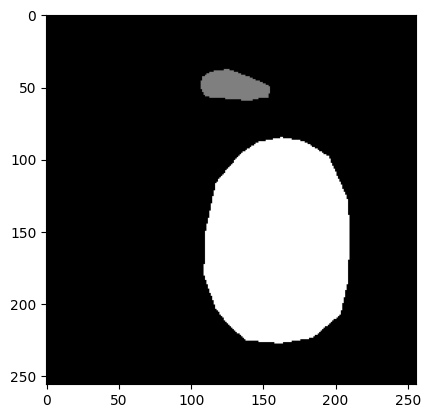

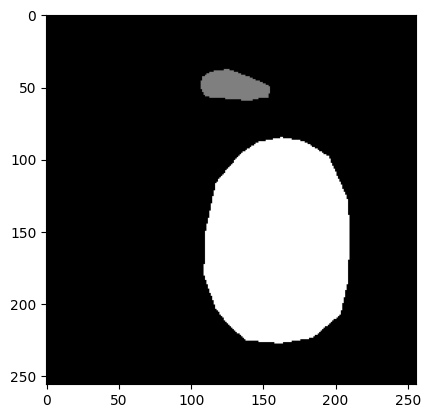

In [2]:
import cv2
import matplotlib.pyplot as plt
mask1 = cv2.imread("/kaggle/input/segmentationdataset/Filtered_Masks-20250123T134808Z-001/Filtered_Masks/00001_PSFHAoP4k_mask.png",0)

mask = cv2.imread("/kaggle/input/segmentationdataset/Filtered_Masks-20250123T134808Z-001/Filtered_Masks/00001_PSFHAoP4k_mask.png",0)  
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       #  detects boundaries
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)      # draws boundary on an image


img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
dataset = CustomDataset(
    img_path='/kaggle/input/segmentationdataset/denoised-20250123T134822Z-001/denoised/Standard_plane',
    target_path='/kaggle/input/segmentationdataset/Filtered_Masks-20250123T134808Z-001/Filtered_Masks',
    transform=transform,
    target_transform=transform1
)

test_dataset = CustomDataset(
    img_path='/kaggle/input/segmentationdataset/TN_images-20250123T134827Z-001/TN_images',
    target_path='/kaggle/input/segmentationdataset/test_Masks-20250123T134752Z-001/test_Masks',
    transform=transform,
    target_transform=transform1
)

# Check the number of images
img_path = '/kaggle/input/segmentationdataset/denoised-20250123T134822Z-001/denoised/Standard_plane'
print(len(os.listdir(img_path)))

target_path = '/kaggle/input/segmentationdataset/Filtered_Masks-20250123T134808Z-001/Filtered_Masks'
print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/segmentationdataset/TN_images-20250123T134827Z-001/TN_images'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/segmentationdataset/test_Masks-20250123T134752Z-001/test_Masks'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7584
7584
1414
1414


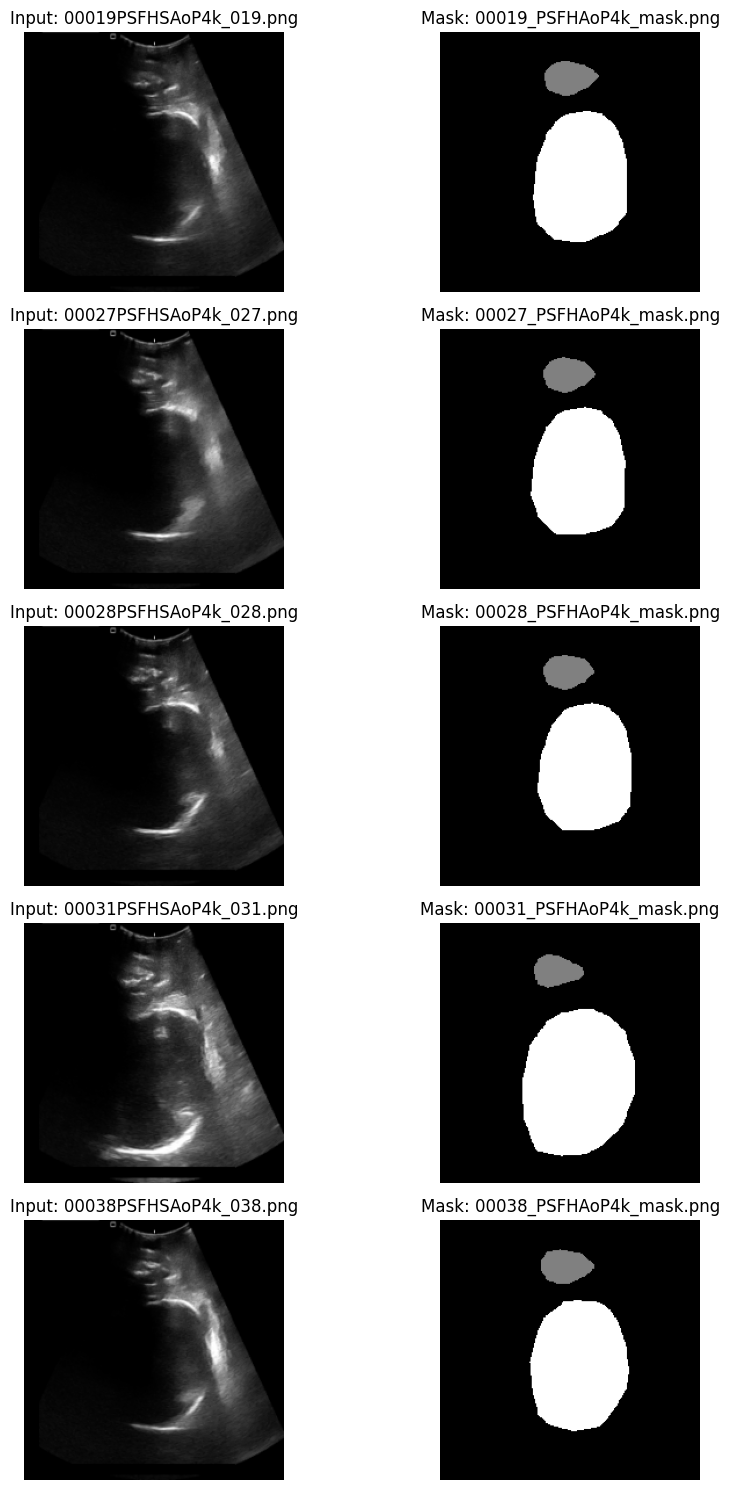

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, running on CPU.")

Using GPU: Tesla T4


In [7]:
from pathlib import Path
import yaml
import torch
import math
import os
import torch.nn as nn

from timm.models.helpers import load_pretrained, load_custom_pretrained
from timm.models.vision_transformer import default_cfgs
from timm.models.registry import register_model
from timm.models.vision_transformer import _create_vision_transformer


import torch.nn.functional as F
from collections import defaultdict
from timm.models.layers import trunc_normal_

from einops import rearrange
from timm.models.layers import DropPath
from timm.models.vision_transformer import _load_weights


def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)


def resize_pos_embed(posemb, grid_old_shape, grid_new_shape, num_extra_tokens):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    posemb_tok, posemb_grid = (
        posemb[:, :num_extra_tokens],
        posemb[0, num_extra_tokens:],
    )
    if grid_old_shape is None:
        gs_old_h = int(math.sqrt(len(posemb_grid)))
        gs_old_w = gs_old_h
    else:
        gs_old_h, gs_old_w = grid_old_shape

    gs_h, gs_w = grid_new_shape
    posemb_grid = posemb_grid.reshape(1, gs_old_h, gs_old_w, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if "model" in state_dict:
        # For deit models
        state_dict = state_dict["model"]
    num_extra_tokens = 1 + ("dist_token" in state_dict.keys())
    patch_size = model.patch_size
    image_size = model.patch_embed.image_size
    for k, v in state_dict.items():
        if k == "pos_embed" and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v,
                None,
                (image_size[0] // patch_size, image_size[1] // patch_size),
                num_extra_tokens,
            )
        out_dict[k] = v
    return out_dict


def padding(im, patch_size, fill_value=0):
    # make the image sizes divisible by patch_size
    H, W = im.size(2), im.size(3)
    pad_h, pad_w = 0, 0
    if H % patch_size > 0:
        pad_h = patch_size - (H % patch_size)
    if W % patch_size > 0:
        pad_w = patch_size - (W % patch_size)
    im_padded = im
    if pad_h > 0 or pad_w > 0:
        im_padded = F.pad(im, (0, pad_w, 0, pad_h), value=fill_value)
    return im_padded


def unpadding(y, target_size):
    H, W = target_size
    H_pad, W_pad = y.size(2), y.size(3)
    # crop predictions on extra pixels coming from padding
    extra_h = H_pad - H
    extra_w = W_pad - W
    if extra_h > 0:
        y = y[:, :, :-extra_h]
    if extra_w > 0:
        y = y[:, :, :, :-extra_w]
    return y


def resize(im, smaller_size):
    h, w = im.shape[2:]
    if h < w:
        ratio = w / h
        h_res, w_res = smaller_size, ratio * smaller_size
    else:
        ratio = h / w
        h_res, w_res = ratio * smaller_size, smaller_size
    if min(h, w) < smaller_size:
        im_res = F.interpolate(im, (int(h_res), int(w_res)), mode="bilinear")
    else:
        im_res = im
    return im_res


def sliding_window(im, flip, window_size, window_stride):
    B, C, H, W = im.shape
    ws = window_size

    windows = {"crop": [], "anchors": []}
    h_anchors = torch.arange(0, H, window_stride)
    w_anchors = torch.arange(0, W, window_stride)
    h_anchors = [h.item() for h in h_anchors if h < H - ws] + [H - ws]
    w_anchors = [w.item() for w in w_anchors if w < W - ws] + [W - ws]
    for ha in h_anchors:
        for wa in w_anchors:
            window = im[:, :, ha : ha + ws, wa : wa + ws]
            windows["crop"].append(window)
            windows["anchors"].append((ha, wa))
    windows["flip"] = flip
    windows["shape"] = (H, W)
    return windows


def merge_windows(windows, window_size, ori_shape):
    ws = window_size
    im_windows = windows["seg_maps"]
    anchors = windows["anchors"]
    C = im_windows[0].shape[0]
    H, W = windows["shape"]
    flip = windows["flip"]

    logit = torch.zeros((C, H, W), device=im_windows.device)
    count = torch.zeros((1, H, W), device=im_windows.device)
    for window, (ha, wa) in zip(im_windows, anchors):
        logit[:, ha : ha + ws, wa : wa + ws] += window
        count[:, ha : ha + ws, wa : wa + ws] += 1
    logit = logit / count
    logit = F.interpolate(
        logit.unsqueeze(0),
        ori_shape,
        mode="bilinear",
    )[0]
    if flip:
        logit = torch.flip(logit, (2,))
    result = F.softmax(logit, 0)
    return result


# def inference(
#     model,
#     ims,
#     ims_metas,
#     ori_shape,
#     window_size,
#     window_stride,
#     batch_size,
# ):
#     C = model.n_cls
#     seg_map = torch.zeros((C, ori_shape[0], ori_shape[1]), device=ptu.device)
#     for im, im_metas in zip(ims, ims_metas):
#         im = im.to(ptu.device)
#         im = resize(im, window_size)
#         flip = im_metas["flip"]
#         windows = sliding_window(im, flip, window_size, window_stride)
#         crops = torch.stack(windows.pop("crop"))[:, 0]
#         B = len(crops)
#         WB = batch_size
#         seg_maps = torch.zeros((B, C, window_size, window_size), device=im.device)
#         with torch.no_grad():
#             for i in range(0, B, WB):
#                 seg_maps[i : i + WB] = model.forward(crops[i : i + WB])
#         windows["seg_maps"] = seg_maps
#         im_seg_map = merge_windows(windows, window_size, ori_shape)
#         seg_map += im_seg_map
#     seg_map /= len(ims)
#     return seg_map


def num_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([torch.prod(torch.tensor(p.size())) for p in model_parameters])
    return n_params.item()







class Segmenter(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        n_cls,
    ):
        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        masks = unpadding(masks, (H_ori, W_ori))

        # Apply softmax to get the final probability map (per-class probability)
        masks = F.softmax(masks, dim=1)
        
        return masks

    def get_attention_map_enc(self, im, layer_id):
        return self.encoder.get_attention_map(im, layer_id)

    def get_attention_map_dec(self, im, layer_id):
        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        return self.decoder.get_attention_map(x, layer_id)








class DecoderLinear(nn.Module):
    def __init__(self, n_cls, patch_size, d_encoder):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x


class MaskTransformer(nn.Module):
    def __init__(
        self,
        n_cls,
        patch_size,
        d_encoder,
        n_layers,
        n_heads,
        d_model,
        d_ff,
        drop_path_rate,
        dropout,
    ):
        super().__init__()
        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.n_cls = n_cls
        self.d_model = d_model
        self.d_ff = d_ff
        self.scale = d_model ** -0.5

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        self.cls_emb = nn.Parameter(torch.randn(1, n_cls, d_model))
        self.proj_dec = nn.Linear(d_encoder, d_model)

        self.proj_patch = nn.Parameter(self.scale * torch.randn(d_model, d_model))
        self.proj_classes = nn.Parameter(self.scale * torch.randn(d_model, d_model))

        self.decoder_norm = nn.LayerNorm(d_model)
        self.mask_norm = nn.LayerNorm(n_cls)

        self.apply(init_weights)
        trunc_normal_(self.cls_emb)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"cls_emb"}

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size

        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        for blk in self.blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        patches, cls_seg_feat = x[:, : -self.n_cls], x[:, -self.n_cls :]
        patches = patches @ self.proj_patch
        cls_seg_feat = cls_seg_feat @ self.proj_classes

        patches = patches / patches.norm(dim=-1, keepdim=True)
        cls_seg_feat = cls_seg_feat / cls_seg_feat.norm(dim=-1, keepdim=True)

        masks = patches @ cls_seg_feat.transpose(1, 2)
        masks = self.mask_norm(masks)
        masks = rearrange(masks, "b (h w) n -> b n h w", h=int(GS))

        return masks

    def get_attention_map(self, x, layer_id):
        if layer_id >= self.n_layers or layer_id < 0:
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        for i, blk in enumerate(self.blocks):
            if i < layer_id:
                x = blk(x)
            else:
                return blk(x, return_attention=True)

"""
Adapted from 2020 Ross Wightman
https://github.com/rwightman/pytorch-image-models
"""




class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = dim
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.heads = heads
        head_dim = dim // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x, attn


class Block(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout, drop_path):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.mlp = FeedForward(dim, mlp_dim, dropout)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x, mask=None, return_attention=False):
        y, attn = self.attn(self.norm1(x), mask)
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


"""
Adapted from 2020 Ross Wightman
https://github.com/rwightman/pytorch-image-models
"""


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        n_cls,
        dropout=0.1,
        drop_path_rate=0.0,
        distilled=False,
        channels=3,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.n_cls = n_cls

        # cls and pos tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.distilled = distilled
        if self.distilled:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, d_model))
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 2, d_model)
            )
            self.head_dist = nn.Linear(d_model, n_cls)
        else:
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 1, d_model)
            )

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # output head
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        if self.distilled:
            trunc_normal_(self.dist_token)
        self.pre_logits = nn.Identity()

        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token"}

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=""):
        _load_weights(self, checkpoint_path, prefix)

    def forward(self, im, return_features=False):
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed
        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if return_features:
            return x

        if self.distilled:
            x, x_dist = x[:, 0], x[:, 1]
            x = self.head(x)
            x_dist = self.head_dist(x_dist)
            x = (x + x_dist) / 2
        else:
            x = x[:, 0]
            x = self.head(x)
        return x

    def get_attention_map(self, im, layer_id):
        if layer_id >= self.n_layers or layer_id < 0:
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed

        for i, blk in enumerate(self.blocks):
            if i < layer_id:
                x = blk(x)
            else:
                return blk(x, return_attention=True)


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    """ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights fine-tuned from in21k @ 384x384, source https://github.com/google-research/vision_transformer.
    """
    model_kwargs = dict(patch_size=16, embed_dim=256, depth=12, num_heads=4, **kwargs)
    model = _create_vision_transformer(
        "vit_base_patch16_224",
        pretrained=pretrained,
        default_cfg=dict(
            url="",
            input_size=(1, 224,224),
            num_classes=3,
        ),
        **model_kwargs,
    )
    return model


# def create_vit(model_cfg):
#     model_cfg = model_cfg.copy()
#     backbone = model_cfg.pop("backbone")

#     normalization = model_cfg.pop("normalization")
#     model_cfg["n_cls"] = 1000
#     mlp_expansion_ratio = 4
#     model_cfg["d_ff"] = mlp_expansion_ratio * model_cfg["d_model"]

#     if backbone in default_cfgs:
#         default_cfg = default_cfgs[backbone]
#     else:
#         default_cfg = dict(
#             pretrained=False,
#             num_classes=1000,
#             drop_rate=0.0,
#             drop_path_rate=0.0,
#             drop_block_rate=None,
#         )

#     default_cfg["input_size"] = (
#         3,
#         model_cfg["image_size"][0],
#         model_cfg["image_size"][1],
#     )
#     model = VisionTransformer(**model_cfg)
#     if backbone == "vit_base_patch16_224":
#         path = os.path.expandvars("$TORCH_HOME/hub/checkpoints/vit_base_patch16_224.pth")
#         state_dict = torch.load(path, map_location="cpu")
#         filtered_dict = checkpoint_filter_fn(state_dict, model)
#         model.load_state_dict(filtered_dict, strict=True)
#     elif "deit" in backbone:
#         load_pretrained(model, default_cfg, filter_fn=checkpoint_filter_fn)
#     else:
#         load_custom_pretrained(model, default_cfg)

#     return model


def create_vit(model_cfg):
    model_cfg = model_cfg.copy()
    backbone = model_cfg.pop("backbone")

    model_cfg["n_cls"] = 3
    mlp_expansion_ratio = 4
    model_cfg["d_ff"] = mlp_expansion_ratio * model_cfg["d_model"]

    # Create the model without loading pre-trained weights
    model = VisionTransformer(**model_cfg)

    # Initialize weights
    model.apply(init_weights)

    return model


def create_decoder(encoder, decoder_cfg):
    decoder_cfg = decoder_cfg.copy()
    name = decoder_cfg.pop("name")
    decoder_cfg["d_encoder"] = encoder.d_model
    decoder_cfg["patch_size"] = encoder.patch_size

    if "linear" in name:
        decoder = DecoderLinear(**decoder_cfg)
    elif name == "mask_transformer":
        dim = encoder.d_model
        n_heads = dim // 64
        decoder_cfg["n_heads"] = n_heads
        decoder_cfg["d_model"] = dim
        decoder_cfg["d_ff"] = 4 * dim
        decoder = MaskTransformer(**decoder_cfg)
    else:
        raise ValueError(f"Unknown decoder: {name}")
    return decoder


def create_segmenter(model_cfg):
    model_cfg = model_cfg.copy()
    decoder_cfg = model_cfg.pop("decoder")
    decoder_cfg["n_cls"] = model_cfg["n_cls"]

    encoder = create_vit(model_cfg)
    decoder = create_decoder(encoder, decoder_cfg)
    model = Segmenter(encoder, decoder, n_cls=model_cfg["n_cls"])

    return model


# def load_model(model_path):
#     variant_path = Path(model_path).parent / "variant.yml"
#     with open(variant_path, "r") as f:
#         variant = yaml.load(f, Loader=yaml.FullLoader)
#     net_kwargs = variant["net_kwargs"]

#     model = create_segmenter(net_kwargs)
#     data = torch.load(model_path, map_location=ptu.device)
#     checkpoint = data["model"]

#     model.load_state_dict(checkpoint, strict=True)

#     return model, variant


# First, create a configuration dictionary for the model
model_cfg = {
    "backbone": "vit_base_patch16_224",  # Choose the backbone
    "image_size": (224, 224),  # Set image size
    "patch_size": 16,  # Patch size
    "n_cls": 3,  # Number of classes
    "d_model": 256,  # Embedding dimension
    "n_layers": 12,  # Number of transformer layers
    "d_ff": 1024,  # Feed-forward dimension
    "n_heads": 4,  # Number of attention heads
    "channels": 1,
    "dropout": 0.1,  # Dropout rate
    "drop_path_rate": 0.1,  # Drop path rate

    # Decoder configuration
    "decoder": {
        "name": "mask_transformer",  # or "linear"
        "n_layers": 2,  # Number of decoder layers
        "d_model": 256,  # Decoder model dimension
         "dropout": 0.1,  # Add dropout
        "drop_path_rate": 0.1,  # Add drop path rate
    }
}

# Create the segmenter model
model = create_segmenter(model_cfg)

# Print model details
print("Model Architecture:")
print(model)


# from torchsummary import summary
# print(summary(model, (1, 224, 224)))

# !pip install torchinfo
from torchinfo import summary
summary(model, input_size=(1, 1, 224, 224))

# Print number of parameters
# print("\nTotal Parameters:", num_params(model))

# # Optional: Move model to GPU if available
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

/usr/local/lib/python3.10/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
<ipython-input-7-f3920aae3fbf>:634: UserWarning: Overwriting vit_base_patch16_224 in registry with __main__.vit_base_patch16_224. This is because the name being registered conflicts with an

Model Architecture:
Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(1, 256, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=256, out_features=1024, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1024, out_features=256, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
      )
   

Layer (type:depth-idx)                   Output Shape              Param #
Segmenter                                [1, 3, 224, 224]          --
├─VisionTransformer: 1-1                 [1, 197, 256]             51,459
│    └─PatchEmbedding: 2-1               [1, 196, 256]             --
│    │    └─Conv2d: 3-1                  [1, 256, 14, 14]          65,792
│    └─Dropout: 2-2                      [1, 197, 256]             --
│    └─ModuleList: 2-3                   --                        --
│    │    └─Block: 3-2                   [1, 197, 256]             789,760
│    │    └─Block: 3-3                   [1, 197, 256]             789,760
│    │    └─Block: 3-4                   [1, 197, 256]             789,760
│    │    └─Block: 3-5                   [1, 197, 256]             789,760
│    │    └─Block: 3-6                   [1, 197, 256]             789,760
│    │    └─Block: 3-7                   [1, 197, 256]             789,760
│    │    └─Block: 3-8                   [1, 19

In [8]:
import torch
torch.cuda.empty_cache()  # Free up unused memory

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [10]:
for batch in train_dataloader:
        inputs, targets, img_names, mask_names = batch
        print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        print(f"Target unique values: {torch.unique(targets)}")
        break

Inputs shape: torch.Size([64, 1, 224, 224]), Targets shape: torch.Size([64, 224, 224])
Target unique values: tensor([0, 1, 2])


In [11]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [12]:
def save_checkpoint(model, optimizer, path, epoch, early_stopping, all_train_loss, all_val_loss, all_train_dice,
                   all_val_dice,all_train_dice_wo, all_val_dice_wo, all_train_jaccard,all_val_jaccard, all_train_voe, all_val_voe, all_train_rvd,
                   all_val_rvd):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'all_train_loss': all_train_loss,
        'all_val_loss': all_val_loss,
        'all_train_dice': all_train_dice,
        'all_val_dice': all_val_dice,
        'all_train_dice_wo': all_train_dice_wo,
        'all_val_dice_wo': all_val_dice_wo,
        'all_train_jaccard': all_train_jaccard,
        'all_val_jaccard': all_val_jaccard,
        'all_train_voe': all_train_voe,
        'all_val_voe': all_val_voe,
        'all_train_rvd': all_train_rvd,
        'all_val_rvd': all_val_rvd,
    }
    torch.save(checkpoint, path)


def save_best_model(model,path):
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint,path)

In [13]:
# def match_dims_with_pred_mask(groundtruth_mask):
#   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

#   num_classes = 3
#   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
#   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

#   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
#   # print("Shape after axis reordering:", groundtruth_mask.shape)
#   return groundtruth_mask


# Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# The more the better
def dice_coef_without_class(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    # print("pred_mask shape: ",pred_mask.shape)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask) + smooth
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 5)

def dice_coef(pred_masks, groundtruth_masks):
    
    pred_masks = np.array(pred_masks)
    # print("pred_masks shape: ",pred_masks.shape)
    groundtruth_masks = np.array(groundtruth_masks)
    # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

    smooth = 1e-6  # Smoothing value to avoid division by zero
    dice_per_class = []
    num_classes = 3

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred_masks == class_idx).astype(np.float32)
        groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

        # Calculate Dice for the current class
        intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
        total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
        dice_class = (2. * intersection + smooth) / (total_sum + smooth)

        # Average Dice across the batch for this class
        dice_per_class.append(np.mean(dice_class))

    # Macro-average Dice (mean across all classes)
    mean_dice = np.mean(dice_per_class)
    return round(mean_dice, 5)

    # smooth = 0.001
    # dice_per_class = torch.zeros(3)
    # for class_id in range(3):
    #     y_pred_class = (pred_masks == class_id).float()
    #     y_true_class = (groundtruth_masks == class_id).float()

    #     intersection = torch.sum(y_pred_class*y_true_class)
    #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
    #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
    #     )

    # return dice_per_class



# Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# The more the better
def iou(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
    return round(np.mean(iou),5)  # Average IoU across all images in the batch


# Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# The less the better


# Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# Lower values are better.
def voe(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
    union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
    voe = 1 - ((intersection+smooth) / (union+smooth))
    return round(voe,5)


# Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# the predicted segmentation overestimates or underestimates the actual volume.
# The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# Example: RVD=−0.2 means the predicted volume is 20% smaller.

# Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# Example: RVD=0.15 means the predicted volume is 15% larger.

# Lower values are better.

def rvd(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    pred_volume = np.sum(pred_mask)  # Sum of intensities
    gt_volume = np.sum(gt_mask)     # Sum of intensities
    rvd = (pred_volume - gt_volume) / (gt_volume)
    return round(rvd,5)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
# from dataset import MyDataset
# from model import UNet

# torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
learning_rate = 0.1
num_epochs = 50
patience = 30
early_stopping = EarlyStopping(patience=patience)
early_stop = False

k_folds = 5
batch_size = 16


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)


train_loaders = []
val_loaders = []
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold + 1}")
    print("-------")

    # for batch in train_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Train Batch:", img_names)  

    # # Print image names for val_loader
    # print(f"Validation images in Fold {fold + 1}:")
    # for batch in val_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Validation Batch:", img_names)
        
    print(f"Train_loader: {len(train_loaders[fold])}")
    print(f"Val_loader: {len(val_loaders[fold])}")

    if (fold+1) % 5 == 0:
        break

print(len(train_loaders))
print(len(val_loaders))



# Define the U-Net architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = create_segmenter(model_cfg).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


PATH = "/kaggle/working/checkpoint_1.pth"
outputCheckpoint_path = "/kaggle/outputs/checkpoint_1.pth"

load_PATH = "/kaggle/input/segmenter_till_epoch_10/pytorch/default/1/checkpoint_1.pth"

bestModel_path = "/kaggle/working/best_model.pth"
output_bestModel_path = "/kaggle/outputs/best_model.pth"


os.makedirs("/kaggle/working", exist_ok=True)
os.makedirs("/kaggle/outputs", exist_ok=True)

# import os
# print(f"File exists: {os.path.exists(load_PATH)}")
# print(f"File size: {os.path.getsize(load_PATH)} bytes")



if (os.path.exists(PATH) and os.path.getsize(PATH) > 0) or (os.path.exists(load_PATH) and os.path.getsize(load_PATH)>0):
    if os.path.exists(load_PATH):
        load_PATH = load_PATH
        print("input LOAD_PATH")
    else:
        load_PATH = PATH
        print("output path")
        
    # checkpoint = torch.load(load_PATH)
    # print(checkpoint['model_state_dict'].keys())
    checkpoint = torch.load(load_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    all_train_loss = checkpoint['all_train_loss']
    all_val_loss = checkpoint['all_val_loss']
    all_train_dice = checkpoint['all_train_dice']
    all_val_dice = checkpoint['all_val_dice']
    all_train_dice_wo = checkpoint['all_train_dice_wo']
    all_val_dice_wo = checkpoint['all_val_dice_wo']
    all_train_jaccard = checkpoint['all_train_jaccard']
    all_val_jaccard = checkpoint['all_val_jaccard']
    all_train_voe = checkpoint['all_train_voe']
    all_val_voe = checkpoint['all_val_voe']
    all_train_rvd = checkpoint['all_train_rvd']
    all_val_rvd = checkpoint['all_val_rvd']

    best_loss = checkpoint['best_loss']
    early_stopping.best_loss = best_loss
    counter = checkpoint['counter']
    early_stopping.counter = counter
    best_model_wts = model.state_dict()
    

    print("Checkpoint loaded successfully!")
    print("counter: ",counter)
    print("best_loss: ",best_loss)
    print("all_train_loss: ",all_train_loss)
    print("all_val_loss: ",all_val_loss)
    print("all train dice: ",all_train_dice)
    print("all val dice: ",all_val_dice)
    print("all train dice wo: ",all_train_dice_wo)
    print("all val dice wo: ",all_val_dice_wo)
    print("all train jaccard: ",all_train_jaccard)
    print("all val jaccard: ",all_val_jaccard)
    print('all train voe: ',all_train_voe)
    print('all val voe: ',all_val_voe)
    print('all train rvd: ',all_train_rvd)
    print('all val rvd: ',all_val_rvd)
    # print("model state dict:\n",model.load_state_dict(checkpoint['model_state_dict']).keys())
    start_epoch += 1
else:
    print("Checkpoint file is empty or missing. Initializing variables.")
    start_epoch = 0
    best_loss = 1e5
    best_model_wts = 0
    all_train_loss, all_val_loss = [], []
    all_train_dice, all_val_dice = [], []
    all_train_dice_wo, all_val_dice_wo = [], []
    all_train_jaccard, all_val_jaccard = [], []
    all_train_voe, all_val_voe = [], []
    all_train_rvd, all_val_rvd = [],[]



print("start_epoch: ",start_epoch)
# Train the U-Net
for epoch in range(start_epoch,num_epochs):
  print("-------epoch: ",epoch)

  fold = epoch % 5
  print("processing fold: ",fold)
  model.train()

#   train_loss = []
#   # train_dice = []
#   true = []
#   pre = []
#   data_iter = iter(train_loaders[fold])
#   inputs, targets, img_names, mask_names = next(data_iter)
#   # print(img_names)
#   # print(mask_names)
    
#   # Forward pass
#   inputs = inputs.to(device)   #
#   targets = targets.to(device)#

#   outputs = model(inputs)
#   loss = criterion(outputs, targets)

#   # Backward pass
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   preds = torch.argmax(outputs, dim=1)

#   true.extend(targets.cpu().numpy())
#   pre.extend(preds.detach().cpu().numpy())

#   train_loss.append(loss.item()) 
# # train_dice.append(dice_score(preds, targets))


#   all_train_loss.append(np.mean(train_loss))
#   train_dice = dice_coef(pre,true)
#   all_train_dice.append(train_dice)
#   train_iou = iou(pre,true)
#   all_train_jaccard.append(train_iou)
#   train_voe = voe(pre,true)
#   all_train_voe.append(train_voe)
#   train_rvd = rvd(pre,true)
#   all_train_rvd.append(train_rvd)

#   print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")


#   with torch.no_grad():
#     model.eval()
#     val_loss = []
#     val_true = []
#     val_pre = []
      
#     val_data_iter = iter(val_loaders[fold])
#     inputs, targets, img_names, mask_names = next(val_data_iter)

#     # print(img_names)
#     # print(mask_names)
        
#     inputs = inputs.to(device)
#     targets = targets.to(device)

#     outputs = model(inputs)
#     loss = criterion(outputs,targets)

#     preds = torch.argmax(outputs, dim=1)

#     val_true.extend(targets.cpu().numpy())
#     val_pre.extend(preds.detach().cpu().numpy())

#     val_loss.append(loss.item())
        
        
  
    
#   all_val_loss.append(np.mean(val_loss))
#   val_dice = dice_coef(val_pre,val_true)
#   all_val_dice.append(val_dice)
#   val_iou = iou(val_pre,val_true)
#   all_val_jaccard.append(val_iou)
#   val_voe = voe(val_pre,val_true)
#   all_val_voe.append(val_voe)
#   val_rvd = rvd(val_pre,val_true)
#   all_val_rvd.append(val_rvd)


#   if np.mean(val_loss) < best_loss:
#         # best_acc = val_accuracy
#         best_loss = np.mean(val_loss)
#         #Save the best model
#         best_model_wts = model.state_dict()
#         torch.save(best_model_wts, bestModel_path)
#         save_best_model(model,output_bestModel_path)
#         print(f"New best model saved with validation loss: {best_loss:.4f}")


#   optimizer.param_groups[0]['lr'] *= 0.9
#   early_stop = early_stopping(model, np.mean(val_loss))
#   print(early_stopping.status)

#   if early_stop:
#      print(f"Early stopping at epoch {epoch + 1}")
#      break
      
#   # Print the loss for the current epoch
#   print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")

    
  train_loss = []
  # train_dice = []
  true = []
  pre = []
  # print("TRAINING:")
  for batch in train_loaders[fold]:
      inputs, targets, img_names, mask_names = batch
      # print("batch_id: ",batch_id)
      # print("each_batch_size: ",len(batch))
      # print(img_names)
      # print(mask_names)
    
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
          
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Unpack the outputs if it's a tuple
      if isinstance(outputs, tuple):
          map_x, map_1, map_2 = outputs
            # Use the first output for predictions and loss
          outputs_for_pred = map_x
      else:
          outputs_for_pred = outputs

      preds = torch.argmax(outputs_for_pred, dim=1)

      true.extend(targets.cpu().numpy())
      pre.extend(preds.detach().cpu().numpy())

      train_loss.append(loss.item())
      # train_dice.append(dice_score(preds, targets))


  all_train_loss.append(np.mean(train_loss))
  train_dice = dice_coef(pre,true)
  all_train_dice.append(train_dice)
  train_dice_wo = dice_coef_without_class(pre,true)
  all_train_dice_wo.append(train_dice_wo)
  train_iou = iou(pre,true)
  all_train_jaccard.append(train_iou)
  train_voe = voe(pre,true)
  all_train_voe.append(train_voe)
  train_rvd = rvd(pre,true)
  all_train_rvd.append(train_rvd)

  print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train_dice_wo: {train_dice_wo}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = []
    val_true = []
    val_pre = []
    # print("VALIDATING")
      
    for batch in val_loaders[fold]:
        inputs, targets, img_names, mask_names = batch
        # print("batch_id: ",val_batch_id)
        # print("each_batch_size: ",len(batch))
        # val_batch_id+=1
        # print(img_names)
        # print(mask_names)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
          
        loss = criterion(outputs,targets)

        # Unpack the outputs if it's a tuple
        if isinstance(outputs, tuple):
            map_x, map_1, map_2 = outputs
            # Use the first output for predictions and loss
            outputs_for_pred = map_x
        else:
            outputs_for_pred = outputs

        preds = torch.argmax(outputs_for_pred, dim=1)

        val_true.extend(targets.cpu().numpy())
        val_pre.extend(preds.detach().cpu().numpy())

        val_loss.append(loss.item())
        
        
  
    
  all_val_loss.append(np.mean(val_loss))
  val_dice = dice_coef(val_pre,val_true)
  all_val_dice.append(val_dice)
  val_dice_wo = dice_coef_without_class(val_pre,val_true)
  all_val_dice_wo.append(val_dice_wo)
  val_iou = iou(val_pre,val_true)
  all_val_jaccard.append(val_iou)
  val_voe = voe(val_pre,val_true)
  all_val_voe.append(val_voe)
  val_rvd = rvd(val_pre,val_true)
  all_val_rvd.append(val_rvd)


  if np.mean(val_loss) < best_loss:
        # best_acc = val_accuracy
        best_loss = np.mean(val_loss)
        #Save the best model
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, bestModel_path)
        save_best_model(model,output_bestModel_path)
        print(f"New best model saved with validation loss: {best_loss:.4f}")


  scheduler.step(np.mean(val_loss))
  early_stop = early_stopping(model, np.mean(val_loss))
  print(early_stopping.status)

  if early_stop:
     print(f"Early stopping at epoch {epoch + 1}")
     break
      
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val_dice_wo: {val_dice_wo}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")
    
  save_checkpoint(model, optimizer, PATH, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss, all_val_loss=all_val_loss,
                  all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                  all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                  all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  save_checkpoint(model, optimizer, outputCheckpoint_path, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss,all_val_loss=all_val_loss,
                 all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                 all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                 all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  print("checkpoint saved successfully")
  # torch.save(model.state_dict(),outputModel_path)

Fold 1
-------
Train_loader: 380
Val_loader: 95
Fold 2
-------
Train_loader: 380
Val_loader: 95
Fold 3
-------
Train_loader: 380
Val_loader: 95
Fold 4
-------
Train_loader: 380
Val_loader: 95
Fold 5
-------
Train_loader: 380
Val_loader: 95
5
5
cuda
input LOAD_PATH
Checkpoint loaded successfully!
counter:  8
best_loss:  0.6939820239418432
all_train_loss:  [0.6998461687251141, 0.6961530512885044, 0.6955642814698972, 0.6955659207544829, 0.6956042278754083, 0.6957990898897773, 0.6960750807272761, 0.6955434010217064, 0.6955060618488412, 0.6956018593750501]
all_val_loss:  [0.695468775222176, 0.6939820239418432, 0.6966623645079764, 0.696395522669742, 0.6962239880310862, 0.6953365526701275, 0.6939835504481667, 0.696563616551851, 0.6964441142584148, 0.6961849921628048]
all train dice:  [0.30627, 0.30692, 0.30706, 0.30704, 0.30703, 0.30699, 0.30692, 0.30706, 0.30704, 0.30703]
all val dice:  [0.30708, 0.30736, 0.30681, 0.30688, 0.30691, 0.30708, 0.30736, 0.30681, 0.30688, 0.30691]
all train dice 

Text(0, 0.5, 'loss')

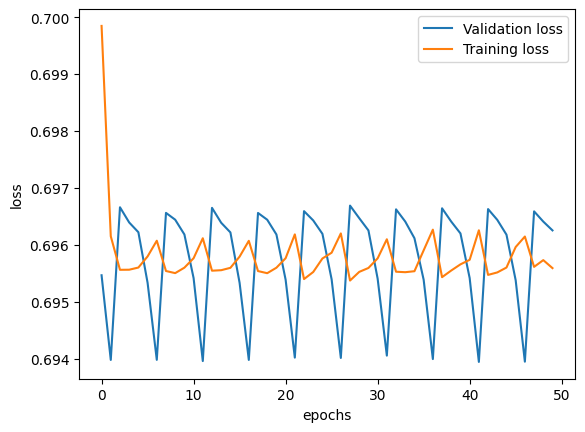

In [15]:
import matplotlib.pyplot as plt
plt.plot(all_val_loss)
plt.plot(all_train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [16]:
import os
import numpy as np
from PIL import Image

# From the best model

model_weight_path = '/kaggle/input/segmenter_till_epoch_10/pytorch/default/1/best_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = create_segmenter(model_cfg).to(device)

model.load_state_dict(torch.load(model_weight_path))
print(model.load_state_dict(torch.load(model_weight_path)))

model.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/predicted_images/"
os.makedirs(output_dir, exist_ok=True)

# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        # outputs = get_ensemble_preds(predicted_masks)
        # Unpack the outputs if it's a tuple
        if isinstance(predicted_masks, tuple):
            map_x, map_1, map_2 = predicted_masks
            # Use the first output for predictions and loss
            outputs_for_pred = map_x
        else:
            outputs_for_pred = predicted_masks
            
        predicted_masks = torch.argmax(outputs_for_pred, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
test_dice = dice_coef(test_pred_msk,test_msk)
test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
test_iou = iou(test_pred_msk,test_msk)
test_voe = voe(test_pred_msk,test_msk)
test_rvd = rvd(test_pred_msk,test_msk)
      
# Print the loss for the current epoch
print(len(all_mask_names))
print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

cuda
<All keys matched successfully>
Saved predicted masks in: /kaggle/outputs/predicted_images/
1414
test dice: 0.3070, test dice wo: 0.0, test jaccard: 0.0, test voe: 1.0, test rvd: -1.0


In [17]:
# MedT till epoch 50
# test dice: 0.8905, test dice wo: 1.81309, test jaccard: 9.7005, test voe: 0.13146, test rvd: -0.0721
# transfuse_s till epoch 50 end at 33 best 3
# test dice: 0.8588, test dice wo: 1.77717, test jaccard: 7.97541, test voe: 0.16214, test rvd: -0.08397

In [18]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        if union != 0:
            voe = (union - intersection) / union
        else:
            voe = 0  # If the union is zero, set VOE to zero (or some other default)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))

In [19]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())


Mean IoU = 0.2852277457714081
Dice Score = 0.30740994215011597
Relative Volume Difference (RVD) = 0.7228856086730957
Volume Overlap Error (VOE) = 0.7147722244262695


In [20]:
# MedT till epoch 50
# Mean IoU = 0.848601758480072
# Dice Score = 0.9134941101074219
# Relative Volume Difference (RVD) = 0.06261571496725082
# Volume Overlap Error (VOE) = 0.15139822661876678
# transfuse till epoch 50 end at 33 best 3
# Mean IoU = 0.8006837964057922
# Dice Score = 0.8794266581535339
# Relative Volume Difference (RVD) = 0.0732102319598198
# Volume Overlap Error (VOE) = 0.19931626319885254

1414
00019PSFHSAoP4k_019.png
00019_PSFHAoP4k_mask.png
00027PSFHSAoP4k_027.png
00027_PSFHAoP4k_mask.png
00028PSFHSAoP4k_028.png
00028_PSFHAoP4k_mask.png
00031PSFHSAoP4k_031.png
00031_PSFHAoP4k_mask.png
00038PSFHSAoP4k_038.png
00038_PSFHAoP4k_mask.png


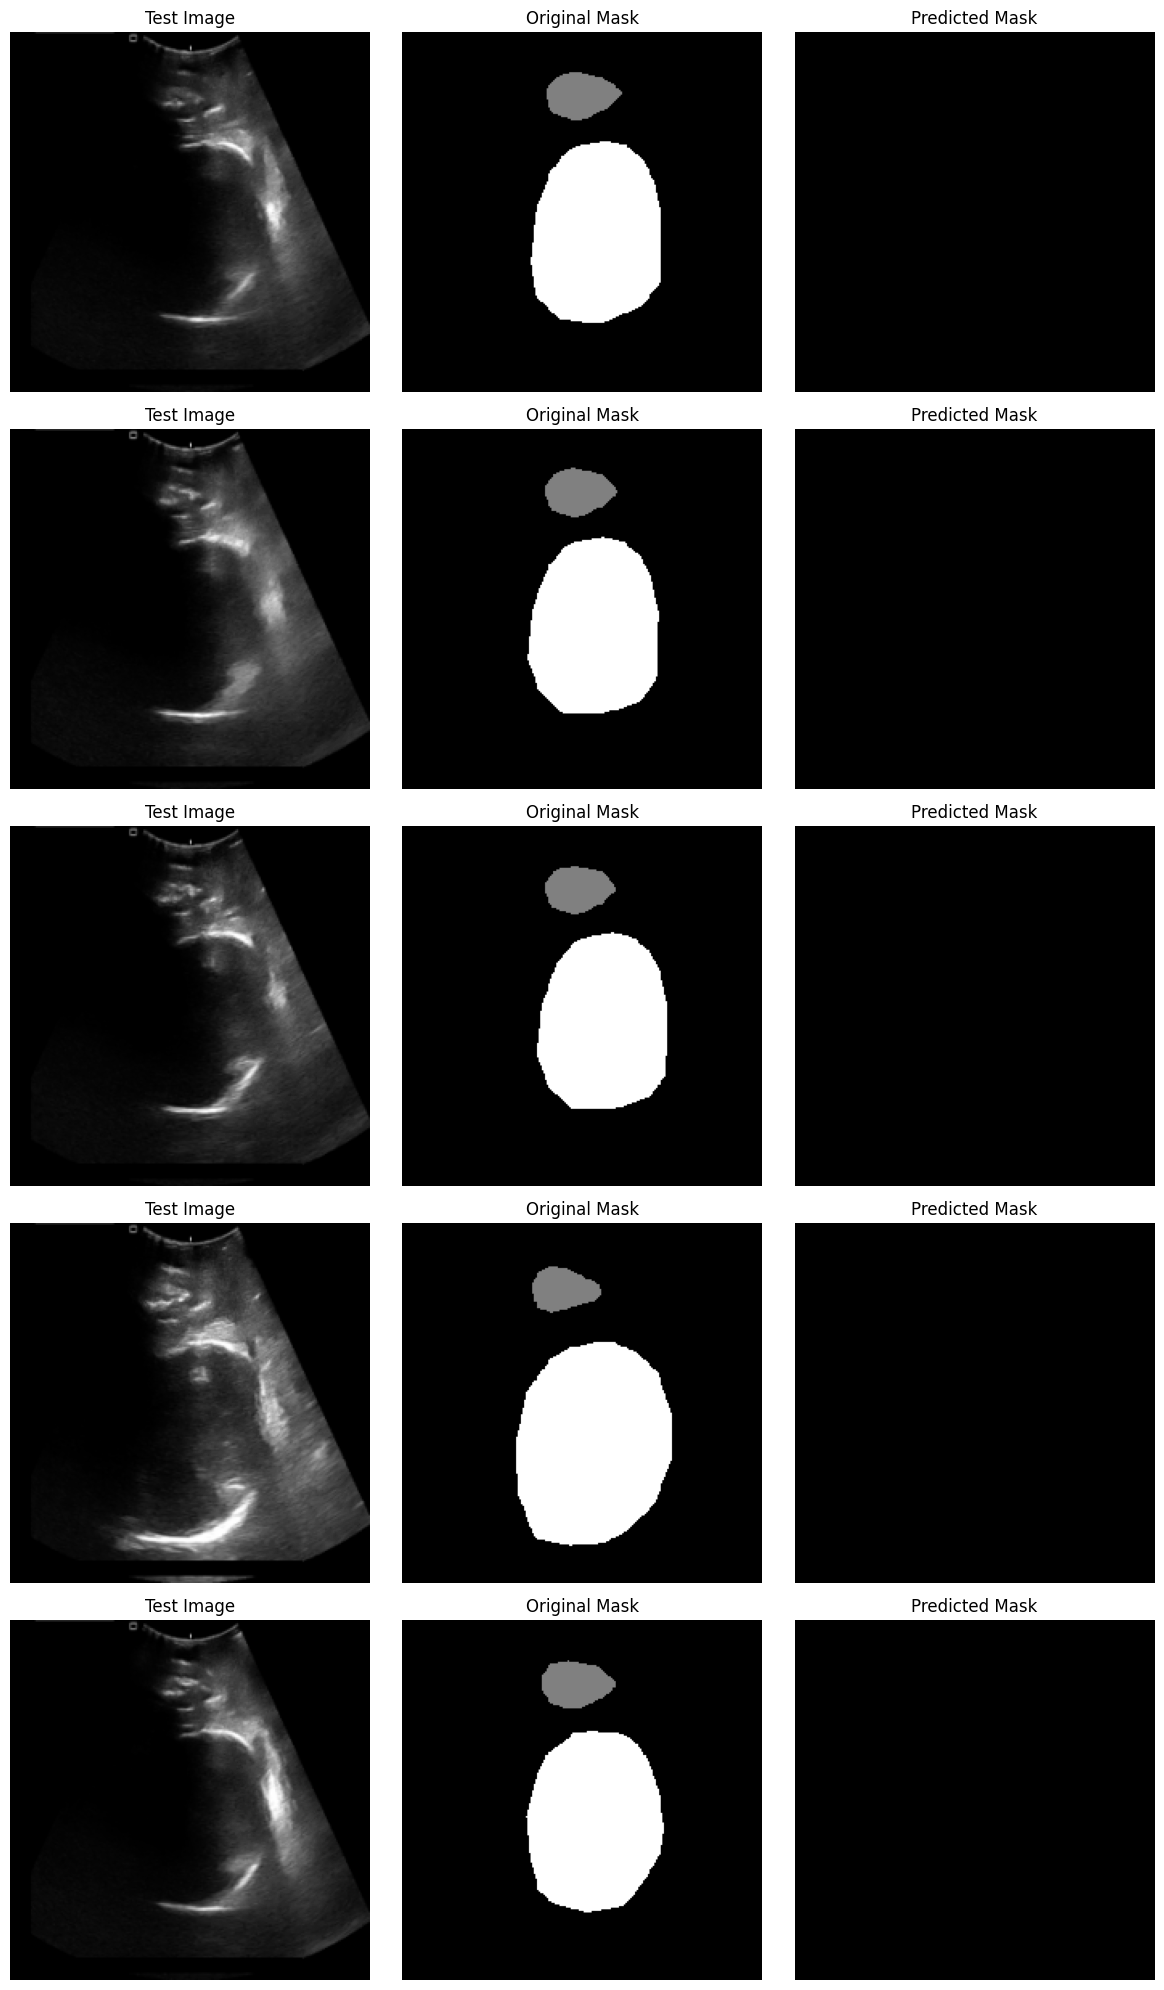

In [21]:
import cv2

test_img = np.array(test_img)
test_msk = np.array(test_msk)
test_pred_msk = np.array(test_pred_msk)

num_images = min(5, test_img.shape[0])  # Show up to 5 images
print(test_img.shape[0])

# Plot original image, ground truth mask, and predicted mask side by side
fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images * 4))

for i in range(num_images):
    print(all_image_names[i])
    print(all_mask_names[i])
    # Original Image
    axs[i, 0].imshow(test_img[i, 0], cmap='gray')  # Assuming grayscale images
    axs[i, 0].set_title("Test Image")
    axs[i, 0].axis("off")

    # Ground Truth Mask
    axs[i, 1].imshow(test_msk[i], cmap='gray')  # Ground truth masks with class labels
    axs[i, 1].set_title("Original Mask")
    axs[i, 1].axis("off")

    # Model-Predicted Mask
    axs[i, 2].imshow(test_pred_msk[i], cmap='gray')  # Predicted masks with class labels
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [22]:
# import cv2

# test_img = np.array(test_img)
# test_msk = np.array(test_msk)
# test_pred_msk = np.array(test_pred_msk)

# output_dir_work = "/kaggle/working/predicted_images/"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# num_images = test_img.shape[0] 

# for i in range(num_images):
#     # Use the original mask name for naming
#     original_name = all_mask_names[i]  # Use the original mask name
#     base_name = os.path.splitext(original_name)[0]  # Get the base name without extension

#     # Save the predicted mask using matplotlib
#     plt.figure(figsize=(8, 8))
#     plt.imshow(test_pred_msk[i], cmap="gray")  # Display as grayscale
#     plt.axis("off")  # Turn off axes for a clean image

#     output_path = os.path.join(output_dir_work, f"{base_name}_predicted.png")
#     plt.savefig(output_path, bbox_inches="tight", pad_inches=0)  # Save without extra margins
#     plt.close()

#     output_path = os.path.join(output_dir, f"{base_name}_predicted.png")
#     plt.savefig(output_path, bbox_inches="tight", pad_inches=0)  # Save without extra margins
#     plt.close()
    

#     if ((i+1)%100==0):
#         print(i+1," images done")